# Detector Hits + Oscillations 1 (Obsolete)

Demonstrate the total number of hits in the IceCube detector after implementaing neutrino oscillations. 

This notebook uses files generated using the notebook `detector_hits_file`.

The progenitor model used is the Nakazato Shen model with z = 0.02, t$_{rev}$ = 300ms, m = 13.0M$_\odot$

In [1]:
from astropy import units as u
from astropy.table import Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from asteria import config, source, detector
from asteria.neutrino import Flavor

mpl.rc('font', size=18)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) and distances (`dist`) at which to perform the simulation. 
The progenitor distance is set to 1 kpc.

In [2]:
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/nakazato-shen-z0.02-t_rev300ms-s13.0.yaml')
ccsn = source.initialize(conf)
ic86 = detector.initialize(conf)

In [4]:
icecube_dt = 2e-3 #s
deadtime = 0.25e-3
dc_rel_eff = 1.35

doms = ic86.doms_table()
n_i3_doms = len(doms[doms['type'] == 'i3'])
n_dc_doms = len(doms[doms['type'] == 'dc'])

i3_dom_bg_mu = 284.9
i3_dom_bg_sig = 26.2

dc_dom_bg_mu = 358.9;
dc_dom_bg_sig = 36.0;

i3_bg_mu  = 2933.72 
i3_bg_sig = 85.8662 

## Define Helper Functions

- `hits` Scale the original signal `signal` calculated for a progenitor at 1 kpc by the distance `dist` of the new progenitor, and use the new signal to generate  and return detector hits for the given progenitor. The deadtime fractions used to generate hits are scaled by the `timebin` being used.

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.

- `background` Use `timebin` to scale the mean background and the uncertainty, and return a randomly sampled array of length `len_array`.

In [5]:
def hits(signal, dist, timebin):
    total_signal = np.sum(signal, axis = 0) / dist**2
    eps_i3 = 0.87 / (1+deadtime* total_signal/timebin)
    eps_dc = 0.87 / (1+deadtime*total_signal*dc_rel_eff/timebin)
    hits = ic86.detector_hits(abs(total_signal), eps_i3, eps_dc)
    return hits

In [6]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    
    rebinned_data = np.sum(np.split( data, new_size ), axis=1)
    rebinned_var  = var.value[int(0.5 * step)::step]   
    
    return rebinned_var, rebinned_data

In [7]:
def background(timebin, len_array):
    # Calculating Background:
    dr  = (n_i3_doms*i3_dom_bg_mu + n_dc_doms*dc_dom_bg_mu ) * timebin;
    dr_er = np.sqrt((n_i3_doms*i3_dom_bg_sig**2 + n_dc_doms*dc_dom_bg_sig**2) * timebin)
    return np.random.normal(dr, dr_er, len_array)

## Read Data from `nakazato-shen-z0.02-t_rev300ms-s13.0_e_per_v.fits`

In [8]:
table = Table.read('nakazato-shen-z0.02-t_rev300ms-s13.0_e_per_v.fits')

In [9]:
sig = np.asarray([table['unmixed nu_e sig'], table['unmixed nu_e_bar sig'], table['unmixed nu_x sig'], table['unmixed nu_x_bar sig']])
sig_norm = np.asarray([table['normal nu_e sig'], table['normal nu_e_bar sig'], table['normal nu_x sig'], table['normal nu_x_bar sig']])
sig_inv = np.asarray([table['inverted nu_e sig'], table['inverted nu_e_bar sig'], table['inverted nu_x sig'], table['inverted nu_x_bar sig']])

In [11]:
# Scale signal to icecube_dt
sig_2ms = []
sig_norm_2ms = []
sig_inv_2ms = []
for i in range(len(Flavor)):
    time_2ms, sig_ = rebin(time, sig[i], dt, icecube_dt)
    time_2ms, sig_norm_ = rebin(time, sig_norm[i], dt, icecube_dt)
    time_2ms, sig_inv_ = rebin(time, sig_inv[i], dt, icecube_dt)
    sig_2ms.append(sig_)
    sig_norm_2ms.append(sig_norm_)
    sig_inv_2ms.append(sig_inv_)

## Generate Plots

### Hits vs time for various progenitor distances

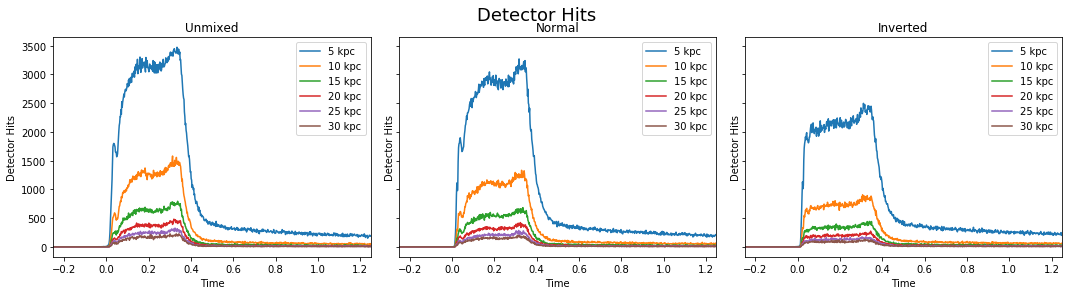

In [23]:
## Plotting nu_e_bar hits for each oscillation scenario
fig, axes = plt.subplots(1, 3, figsize = (15, 4), sharex = True, sharey = True)
ax1, ax2, ax3 = axes
fig.suptitle(r'Detector Hits', fontsize = 18, y = 1.015)
for d in range(5, 31, 5):
    new_hits = hits(sig_2ms, d, icecube_dt)
    hits_n = hits(sig_norm_2ms, d, icecube_dt)
    hits_i = hits(sig_inv_2ms, d, icecube_dt)
    
    ax1.plot(time_2ms, new_hits, label = '{0} kpc'.format(d))
    ax1.set(#xlim = (0, 0.1),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Unmixed')
    ax1.legend()
    
    ax2.plot(time_2ms, hits_n, label = '{0} kpc'.format(d))
    ax2.set(xlim = (-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Normal')
    ax2.legend()
    
    ax3.plot(time_2ms, hits_i, label = '{0} kpc'.format(d))
    ax3.set(#xlim = (-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Inverted')
    ax3.legend()

fig.tight_layout()
# fig.subplots_adjust(top = 0.88)


### Hits +  Backgroud for 10kpc

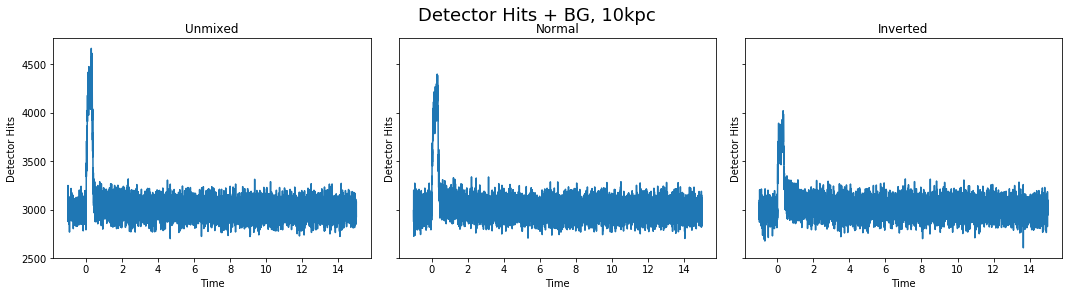

In [24]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4), sharex = True, sharey = True)
ax1, ax2, ax3 = axes
fig.suptitle(r'Detector Hits + BG, 10kpc', fontsize = 18, y = 1.017)
new_hits = hits(sig_2ms, 10, icecube_dt)
hits_n = hits(sig_norm_2ms, 10, icecube_dt)
hits_i = hits(sig_inv_2ms, 10, icecube_dt)

ax1.plot(time_2ms, new_hits + background(icecube_dt, len(time_2ms)))
ax1.set(#xlim = (0, 0.1),
       xlabel = 'Time',
       ylabel = 'Detector Hits',
       title = 'Unmixed')

ax2.plot(time_2ms, hits_n + background(icecube_dt, len(time_2ms)))
ax2.set(#xlim = (-0.25, 1.25),
       xlabel = 'Time',
       ylabel = 'Detector Hits',
       title = 'Normal')

ax3.plot(time_2ms, hits_i + background(icecube_dt, len(time_2ms)))
ax3.set(#xlim = (-0.25, 1.25),
       xlabel = 'Time',
       ylabel = 'Detector Hits',
       title = 'Inverted')

fig.tight_layout()
# fig.subplots_adjust(top = 0.88)
